# Des ODE avec Jax ?

In [31]:
%matplotlib ipympl
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
from dataclasses import dataclass
from jax.tree_util import register_dataclass
from diffrax import ODETerm, Dopri5, SaveAt, PIDController, diffeqsolve

jax.config.update("jax_enable_x64", True)

## Problème

On s'intéresse à une paire d'oscillateurs linéaires couplés par une raideur $K_{12}$. 
On voudrait trouver un régime permanent de manière simple, par exemple en simulant quelques périodes d'excitation. 

L'équation différentielle est:

$$
\left \lbrace 
\begin{split}
M_1  \ddot x_1 + D_1  \dot x_1 + K_1  x_1 + K_{12} (x_1 - x_2) = F_{d1} \sin (w_d t)  \\
M_2  \ddot x_2 + D_2  \dot x_2 + K_2  x_1 + K_{12} (x_2 - x_1) = F_{d2} \sin (w_d t) 
\end{split}
\right .
$$


Et d'un point de vue physique, on voudrait connaitre les énergies dissipées par les amortissements $D_1$ et $D_2$ en régime permanent.

:::{note}
Il est possible de simplifier grandement cette équation en l'adimensionnant mais on fait le choix de ne pas le faire ici.
:::

On la traduit comme suit en Python:

1. On crée une classe pour stocker les paramètres du problème. C'est une solution assez pratique pour éviter de passer trop d'arguments à l'ODE et on peut gérer ça de manière transparente avec Jax.


:::{warning}
Les paramètres par défaut sont pris au pif, c'est une mauvaise idée. Si vous avez mieux, dites le moi !
:::

In [32]:
@register_dataclass
@dataclass
class CoupleLinearResonatorParams:
    """
    Parameters for the coupled linear resonator ODE system.
    """

    M1: float = 1.0  # Mass 1
    M2: float = 1.0  # Mass 2
    K1: float = 1.0  # Spring constant 1
    K2: float = 1.0  # Spring constant 2
    K12: float = 0.1  # Coupling spring constant 2
    D1: float = 0.01  # Damping coefficient 1
    D2: float = 0.01  # Damping coefficient 2
    wd: float = 2.0 * jnp.pi  # Driving frequency
    Fd1: float = 0.5  # Driving force amplitude 1
    Fd2: float = 0.5  # Driving force amplitude 2


ode_params = CoupleLinearResonatorParams(Fd2=0.0)
ode_params

CoupleLinearResonatorParams(M1=1.0, M2=1.0, K1=1.0, K2=1.0, K12=0.1, D1=0.01, D2=0.01, wd=6.283185307179586, Fd1=0.5, Fd2=0.0)

2. On écrit l'ODE:

In [33]:
def coupled_linear_resonator_ode(t, X, params: CoupleLinearResonatorParams):
    x1, v1, x2, v2, E1, E2 = X
    dx1dt = v1
    dv1dt = (
        -params.K1 * x1
        - params.K12 * (x1 - x2)
        - params.D1 * v1
        + params.Fd1 * jnp.sin(params.wd * t)
    ) / params.M1
    dx2dt = v2
    dv2dt = (
        -params.K2 * x2
        - params.K12 * (x2 - x1)
        - params.D2 * v2
        + params.Fd2 * jnp.sin(params.wd * t)
    ) / params.M2
    P1 = v1**2 * params.D1
    P2 = v2**2 * params.D2
    return jnp.array([dx1dt, dv1dt, dx2dt, dv2dt, P1, P2])


X0 = jnp.array(
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
)  # Initial state: [x1, v1, x2, v2, E1, E2]
t = 0.2  # Initial time
coupled_linear_resonator_ode(t, X0, ode_params)

Array([0.        , 0.47552826, 0.        , 0.        , 0.        ,
       0.        ], dtype=float64)

Ok, notre ODE fonctionne.


3. Essayons de l'intégrer:

In [34]:
term = ODETerm(coupled_linear_resonator_ode)  # Define the ODE term
solver = Dopri5()  # Choose the Dormand-Prince 5(4) solver
t0 = 0.0  # Initial time
t1 = 200.0  # Final time
ode_params = CoupleLinearResonatorParams(
    Fd2=1.0,
    Fd1=1.0,
    K1=1.0,
    K2=1.0,
    wd= 2.0 * jnp.pi,
    K12=0,
    D1=.005,
    D2=.005,
    M1= (4.0 * jnp.pi**2)**-1,
    M2= (4.0 * jnp.pi**2)**-1,
)
saveat = SaveAt(ts=jnp.linspace(t0, t1, 10000))  # Specify time points to save the solution
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
sol = diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=0.1,
    y0=X0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    args=ode_params,
)
t = np.array(sol.ts)
x1 =np.array(sol.ys[:, 0])
v1 =np.array(sol.ys[:, 1])
x2 =np.array(sol.ys[:, 2])
v2 =np.array(sol.ys[:, 3])
E1 =np.array(sol.ys[:, 4])
E2 =np.array(sol.ys[:, 5])


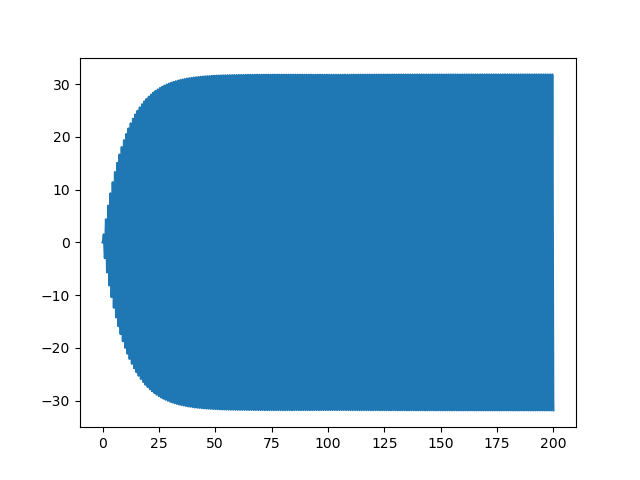

In [35]:
plt.figure()
plt.plot(t, x1)

    

Ok cela fonctionne, on peut donc construire une fonction qui fait la tâche demandée:



In [36]:
@register_dataclass
@dataclass
class CalculateSteadyStatePowerParams:
    t0: float = 0.0
    t1: float = 5.0
    max_steps: int = 100000


def calculate_steady_state_power(
    X0,
    ode_params: CoupleLinearResonatorParams,
    calc_params: CalculateSteadyStatePowerParams,
):
    """
    Calculate the steady-state power dissipated by each resonator.

        A tuple containing the steady-state power dissipated by resonator 1 and resonator
    """
    term = ODETerm(coupled_linear_resonator_ode)  # Define the ODE term
    solver = Dopri5()  # Choose the Dormand-Prince 5(4) solver
    t0 = calc_params.t0  # Initial time
    t1 = calc_params.t1  # Final time
    Td = 2 * jnp.pi / ode_params.wd  # Driving period
    t2 = t1 + Td

    saveat0 = SaveAt(ts=[t0, t1])  # Specify time points to save the solution
    stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)
    sol0 = diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        dt0=0.01,
        y0=X0,
        saveat=saveat0,
        stepsize_controller=stepsize_controller,
        max_steps=calc_params.max_steps,
        args=ode_params,
    )
    X1 = sol0.ys[-1]  # State at time t1
    X1 = X1.at[4:].set(0.0)  # Reset accumulated power to zero
    saveat1 = SaveAt(ts=[t1, t2])  # Specify time points to save the solution
    stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)
    sol1 = diffeqsolve(
        term,
        solver,
        t0=t1,
        t1=t2,
        dt0=0.01,
        y0=X1,
        saveat=saveat1,
        stepsize_controller=stepsize_controller,
        max_steps=calc_params.max_steps,
        args=ode_params,
    )
    X2 = sol1.ys[-1]  # State at time t2
    P = (X2[4:]) / Td  # Average power dissipated over one period
    return P


P = calculate_steady_state_power(
    X0, ode_params, CalculateSteadyStatePowerParams(t0=0.0, t1=100.0)
)
P

Array([99.99015406, 99.99015406], dtype=float64)

On peut donc calculer les puissances en régime établi pour les 2 oscillateurs. 
Faisons maintenant une étude paramétrique avec `vmap`:

In [ ]:
K1v = jnp.linspace(0.5, 2.0, 50)
K12v = jnp.linspace(0.5, 2.0, 50)

vcalc_steady_state_power = vmap(
    vmap(
        calculate_steady_state_power,
        in_axes=(
            None,
            CoupleLinearResonatorParams(
                M1=None,
                M2=None,
                K1=0,
                K2=None,
                K12=None,
                D1=None,
                D2=None,
                wd=None,
                Fd1=None,
                Fd2=None,
            ),
            None,
        ),
    ),
    in_axes=(
        None,
        CoupleLinearResonatorParams(
            M1=None,
            M2=None,
            K1=None,
            K2=None,
            K12=0,
            D1=None,
            D2=None,
            wd=None,
            Fd1=None,
            Fd2=None,
        ),
        None,
    ),
)
ode_params2 = CoupleLinearResonatorParams(
    Fd2=0.0,
    Fd1=1.0,
    K1=K1v,
    K2=1.0,
    wd= 2.0 * jnp.pi,
    K12=K12v,
    D1=.01,
    D2=.01,
    M1= (4.0 * jnp.pi**2)**-1,
    M2= (4.0 * jnp.pi**2)**-1,
)
calc_params2 = CalculateSteadyStatePowerParams(t0=0.0, t1=200.0)
P2 = vcalc_steady_state_power(
    X0, 
    ode_params2, 
    calc_params2
)
P2.shape

(50, 50, 2)

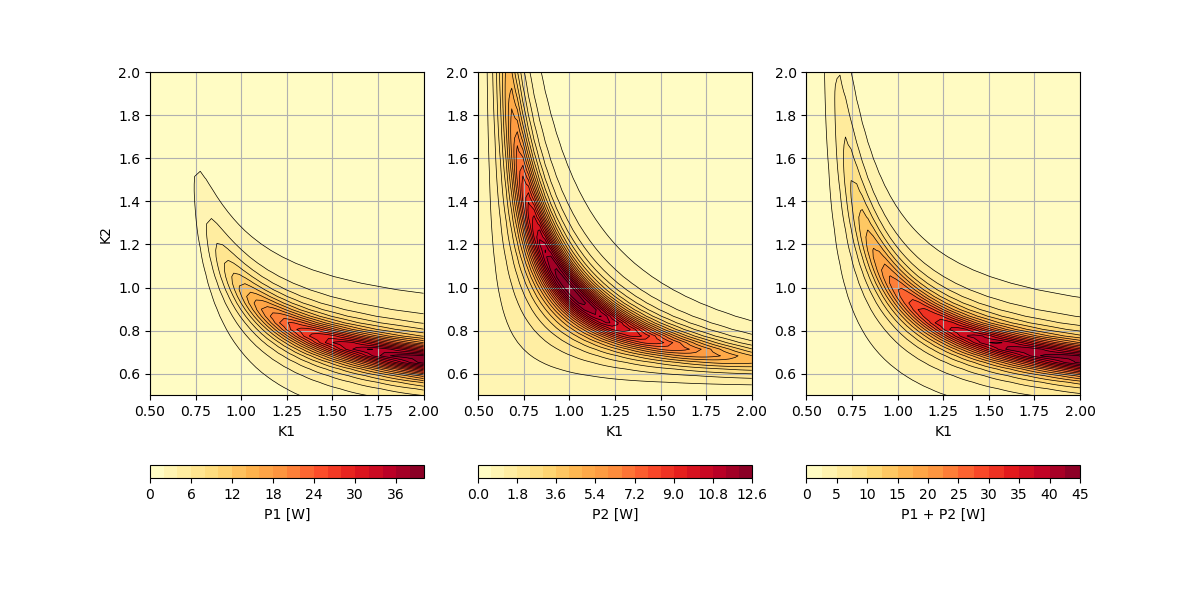

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(131)
plt.contourf(K1v, K12v, P2[:, :, 0].T, levels=20, cmap="YlOrRd")
plt.colorbar(
    label="P1 [W]", orientation="horizontal"
)
plt.contour(K1v, K12v, P2[:, :, 0].T, levels=20, colors="black", linewidths=0.5)
plt.xlabel("K1")
plt.ylabel("K12")
plt.grid()
ax1 = fig.add_subplot(132)
plt.contourf(K1v, K12v, P2[:, :, 1].T, levels=20, cmap="YlOrRd")
plt.colorbar(
    label="P2 [W]", orientation="horizontal"
)
plt.contour(K1v, K12v, P2[:, :, 1].T, levels=20, colors="black", linewidths=0.5)
plt.xlabel("K1")
# plt.ylabel("K2")
plt.grid()
ax1 = fig.add_subplot(133)
plt.contourf(K1v, K12v, P2[:, :, 1].T + P2[:, :, 0].T, levels=20, cmap="YlOrRd")
plt.colorbar(
    label="P1 + P2 [W]", orientation="horizontal"
)
plt.contour(K1v, K12v, P2[:, :, 1].T + P2[:, :, 0].T, levels=20, colors="black", linewidths=0.5)
plt.xlabel("K1")
# plt.ylabel("K2")
plt.grid()
plt.show()

C'est beau mais assez étrange. A discuter !

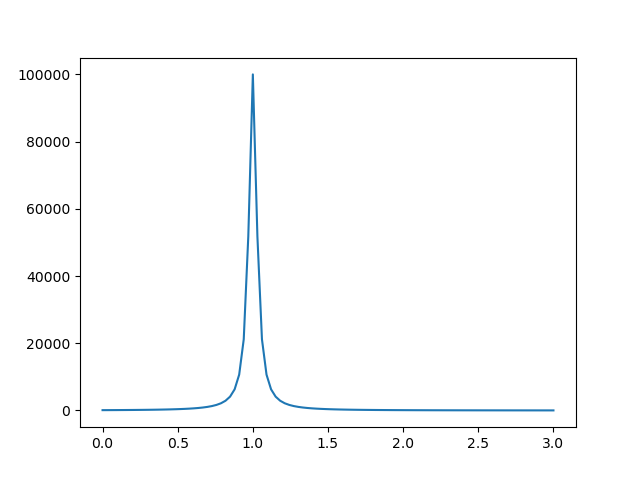

In [41]:
plt.figure()
plt.plot(K1v, P2[0, :, 0] * 1.0e3)
plt.show()